In [1]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import copy
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, precision_score
from sklearn.model_selection import train_test_split

In [154]:
#Define a function that calculates the percentage of Ntest patients in each of nclass classes
#Return these probabilities, as well as the prediction for the next observed patient.
def observe(tseries,Ntest,nclass):
    testp = tseries.copy()
    ratios = []
    for i in range(nclass):
        n = len(testp[testp==(float(i)+1.)])
        ratios.append(float(n)/float(Ntest))
    ratios = np.array(ratios)
    pred = np.random.multinomial(1,ratios)
    pclass = np.where(pred==1)[0]
    return ratios, pclass

### Simulating Categorization Data###

Assuming there are two (or n) Poisson processes generating patients with different diagnoses at different rates, how well can you do in predicting the diagnosis of the next patient by using N previous diagnoses to determine p(diagnosis)?

1) If all rates are constant in time: theoretically, the precision of the classifier should also be constant in time.

2) Rate changing seasonally: the precision should depend on N, and change with time.

3) Rate changing linearly: same as above.

In [200]:
#Generate three datasets to begin with - two constant rates, one monotonically changing rate, and one oscillating 
#rate. 
#Using a Gillespie algorithm stolen from Wikipedia, the source of all knowledge.
w1 = 1.
w2 = 1.5
W = w1 + w2

patients = []
T = 1000.
t = 0.
print('generating data, constant...')
#while t < T:
while len(patients)<5000:
    dt = -np.log(np.random.random_sample()) / W
    t = t + dt

    if np.random.random_sample() < w1 / W:
        patID = 1.
    else:
        patID = 2.
    patients.append((t,patID))
patients = np.array(patients)


patients_sec = []
w1 = 1.5
t = 0.
print('generating data, sec...')
#while t < T:
while len(patients_sec)<5000:
    w2 = 0.5 + 0.025*t
    W = w1 + w2
    dt = -np.log(np.random.random_sample()) / W
    t = t + dt
    
    if np.random.random_sample() < w1 / W:
        patID = 1.
    else:
        patID = 2.
    patients_sec.append((t,patID))
patients_sec = np.array(patients_sec)

patients_sin = []
w1 = 0.5
t = 0.0001
print('generating data, sin...')
#while t < T:
while len(patients_sin)<5000:
    w1 = 1.0
    w2 = 0.5 + 5.*(np.sin(0.01*t))**2
    W = w1 + w2
    dt = -np.log(np.random.random_sample()) / W
    t = t + dt
    
    if np.random.random_sample() < w1 / W:
        patID = 1.
    else:
        patID = 2.
    patients_sin.append((t,patID))
patients_sin = np.array(patients_sin)

generating data, constant...
generating data, sec...
generating data, sin...


calculating average precision...


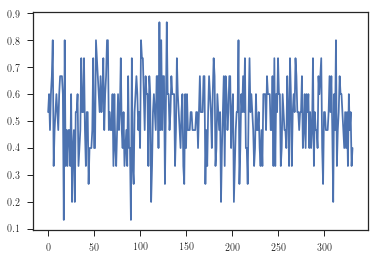

In [201]:
#You want something you can plot as a function of time here, so we will calculate the average precision
#over a window of observations.

window = 15   #Number of calculations to include in the average
Ntrail = 5  #Number of trailing patients to use to predict the next diagnosis

ypred = []    #prediction
yobs = []     #observation
pwind_constant = []    #precision averaged over the window

print('calculating average precision...')
i = 0
for obs in patients[Ntrail+1:,1]:
        r, p = observe(patients[i:Ntrail+i,1],Ntrail,2)
        if Ntrail+i+1<len(patients):
            ypred.append(p[0]+1.)
            yobs.append(obs)
        else:
            print Ntrail*(i+1), i
            break
        i += 1
        if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pwind_constant.append(pscore)
            ypred = []
            yobs = []


#If you are assigning the categories at random, you expect to get an average precision of 50%. But that's not
#what you're doing. As Ntrail goes to the length of the dataset, the probability of assignment goes to the true
#proportion in the population. If the assignment probability is the same as the proportion present in the population,
#the precision for two classes will be p = p_0^2 + p_1^2
plt.plot(pwind_constant)
#plt.hlines(xmin=0,xmax=500,y=0.56,color='red') #predicted value when one rate is twice the other.
#plt.xlim(0,250)

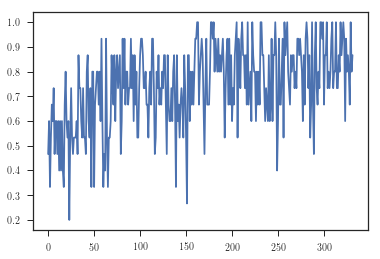

In [202]:
ypred = []    #prediction
yobs = []     #observation
pwind_sec = []    #precision averaged over the window

i = 0
for obs in patients_sec[Ntrail+1:,1]:
        r, p = observe(patients_sec[i:Ntrail+i,1],Ntrail,2)
        if Ntrail+i+1<len(patients_sec):
            ypred.append(p[0]+1.)
            yobs.append(obs)
        else:
            print Ntrail*(i+1), i
            break
        i += 1
        if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pwind_sec.append(pscore)
            ypred = []
            yobs = []

plt.plot(pwind_sec)

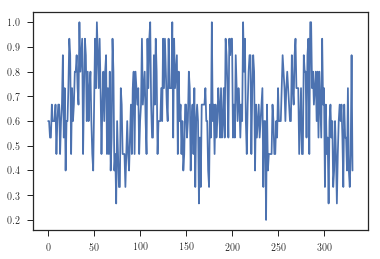

In [191]:
#finally: sinusoidal rate

pwind_osc = []
i = 0
ypred = []
yobs = []
for obs in patients_sin[Ntrail+1:,1]:
        r, p = observe(patients_sin[i:Ntrail+i,1],Ntrail,2)
        if Ntrail+i+1<len(patients_sin):
            ypred.append(p[0]+1.)
            yobs.append(obs)
        else:
            print Ntrail*(i+1), i
            break
        i += 1
        if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pwind_osc.append(pscore)
            ypred = []
            yobs = []
plt.plot(pwind_osc)


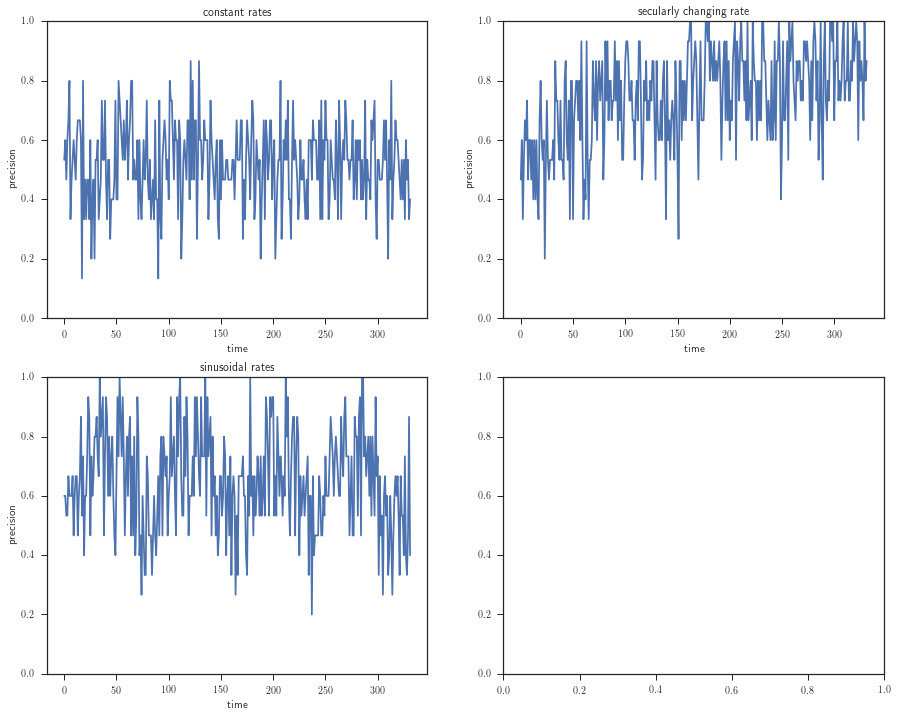

In [203]:
fig, ax = plt.subplots(2,2,figsize=(15,12))
ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax1.plot(pwind_constant)
ax1.set_xlabel('time')
ax1.set_ylabel('precision')
ax1.set_title('constant rates')
ax1.set_ylim(0,1)
ax2.plot(pwind_sec)
ax2.set_ylim(0,1)
ax2.set_xlabel('time')
ax2.set_ylabel('precision')
ax2.set_title('secularly changing rate')
ax3.plot(pwind_osc)
ax3.set_xlabel('time')
ax3.set_ylabel('precision')
ax3.set_title('sinusoidal rates')
ax3.set_ylim(0,1)

plt.savefig('predictive_precision.png')

In [85]:
#You want to compare this to using 'all previous' patients to 'train' the classifier
#You also want to compare this to using some subset at the beginning to classify all future patients, which
#is what you're doing if you never update a classifier

In [221]:

ypred = []
yobs = []
pall = []
pall_sec = []
pall_sin = []
print len(patients), len(patients_sec)
for i in range(5,len(patients)-1):
    past = patients[0:i,1]
    r,p = observe(past,i,2)
    yobs.append(patients[i,1])
    ypred.append(p[0]+1.)
    if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pall.append(pscore)
            ypred = []
            yobs = []
for i in range(5,len(patients_sec)-1):            
    past = patients_sec[0:i,1]
    r,p = observe(past,i,2)
    yobs.append(patients[i,1])
    ypred.append(p[0]+1.)
    if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pall_sec.append(pscore)
            ypred = []
            yobs = []
            
for i in range(5,len(patients_sin)-1):            
    past = patients_sin[0:i,1]
    r,p = observe(past,i,2)
    yobs.append(patients[i,1])
    ypred.append(p[0]+1.)
    if i%window==0:
            yobs = np.array(yobs)
            ypred = np.array(ypred)
            pscore = precision_score(yobs,ypred,average='micro')
            pall_sin.append(pscore)
            ypred = []
            yobs = []

5000 5000


In [218]:
print np.shape(pall_sec)

(333,)


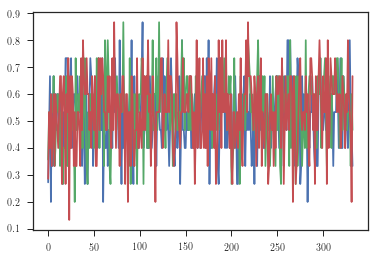

In [222]:
plt.plot(pall)
plt.plot(pall_sec)
plt.plot(pall_sin)

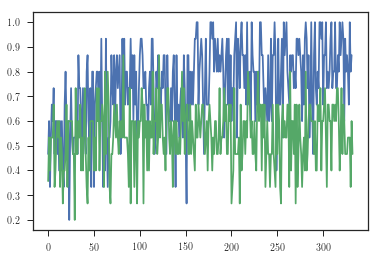

In [224]:
plt.plot(pwind_sec)
plt.plot(pall_sec)

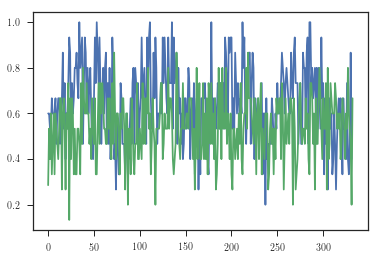

In [225]:
plt.plot(pwind_osc)
plt.plot(pall_sin)